In [3]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import random as rd

df = pd.read_csv("house_data_sampled.csv").sample(100)
df.head()
df.columns

# plt.scatter(df['sqft_living'], df["price"])
# plt.title("Sqft / price")
# plt.show()

# plt.scatter(df['grade'], df["price"])
# plt.title("sqft lot")
# plt.show()

Index(['Unnamed: 0', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [10]:
# Standarizing mileage, grade and year
# mileage
mean_sqft_living = df['sqft_living'].mean()
std_sqft_living = df['sqft_living'].std()
analytical_data = df

analytical_data['c_sqft_living'] = df['sqft_living'] - mean_sqft_living
analytical_data['s_sqft_living'] = analytical_data.c_sqft_living/std_sqft_living

# grade
mean_grade = df['grade'].mean()
std_grade = df['grade'].std()
analytical_data['c_grade'] = df['grade'] - mean_grade
analytical_data['s_grade'] = analytical_data.c_grade/std_grade

print(analytical_data.columns)
analytical_data.head(10)

Index(['Unnamed: 0', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'c_sqft_living', 's_sqft_living', 'c_grade', 's_grade'],
      dtype='object')


,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,c_sqft_living,s_sqft_living,c_grade,s_grade
16,13,6054650070,20141007T000000,400000.0,3,1.75,1370,9680,1.0,0,...,0,98074,47.6127,-122.045,1370,10208,-783.86,-0.906981,-0.84,-0.734620
12,12702,4321200580,20150125T000000,575000.0,3,2.50,1760,2320,2.0,0,...,0,98126,47.5723,-122.376,1760,4698,-393.86,-0.455723,0.16,0.139928
34,16718,7283900185,20140604T000000,415000.0,4,2.50,2000,5962,2.0,0,...,0,98133,47.7695,-122.350,1790,10500,-153.86,-0.178027,0.16,0.139928
97,13825,5637200450,20141017T000000,257000.0,5,2.75,2930,10148,2.0,0,...,0,98059,47.4887,-122.145,2930,8425,776.14,0.898048,1.16,1.014475
86,17429,7222000244,20150223T000000,300000.0,3,3.00,2850,9375,1.0,0,...,0,98055,47.4655,-122.209,1800,9375,696.14,0.805483,0.16,0.139928
91,18668,5490700035,20140807T000000,325000.0,4,1.50,1870,7220,2.0,0,...,0,98155,47.7700,-122.319,1550,7592,-283.86,-0.328446,-0.84,-0.734620
82,20944,2754700035,20141125T000000,925000.0,5,3.50,3420,4216,2.0,0,...,0,98115,47.6799,-122.304,1420,4500,1266.14,1.465012,1.16,1.014475
81,219,7611200125,20141023T000000,467000.0,2,1.50,1320,10800,1.0,0,...,0,98177,47.7145,-122.367,2120,12040,-833.86,-0.964834,0.16,0.139928
58,1428,2481630070,20150128T000000,914600.0,4,3.00,3180,80837,2.0,0,...,0,98072,47.7336,-122.134,3180,38715,1026.14,1.187316,3.16,2.763570
44,5014,3362401815,20140930T000000,764000.0,3,2.00,1420,4080,1.5,0,...,0,98103,47.6801,-122.348,1220,3060,-733.86,-0.849127,0.16,0.139928


<AxesSubplot:>

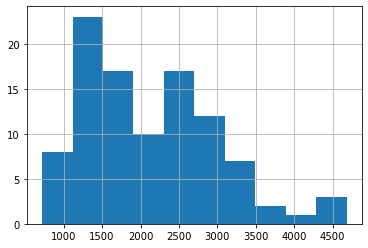

In [317]:
df['sqft_living'].hist()

<AxesSubplot:>

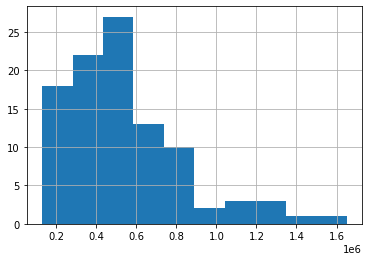

In [318]:
df['price'].hist()

<AxesSubplot:>

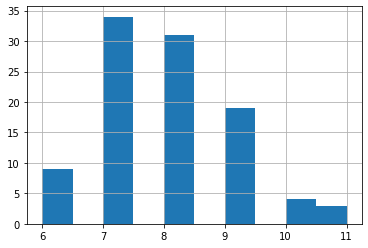

In [319]:
df['grade'].hist()

In [320]:
data = {'N': len(df['sqft_living']),
        'sqft': df['sqft_living']}
model_1_prior = CmdStanModel(stan_file='stan_1_ppc.stan')
model_1_prior_simulated = model_1_prior.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [321]:
model_1_prior_simulated.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
alpha,44000.0,77.0,2500.0,40000.0,44000.0,48000.0,1100.0,11000.0,1.0
beta,280.0,4.5,150.0,12.0,280.0,530.0,1200.0,12000.0,1.0
sigma,330.0,9.2,320.0,20.0,230.0,980.0,1200.0,12000.0,1.0
price[1],987964.0,15473.0,525735.0,87185.0,999164.0,1853540.0,1154.0,12152.0,1.0
...,...,...,...,...,...,...,...,...,...
price[96],328278.0,4663.0,158376.0,56545.0,331998.0,590096.0,1154.0,12146.0,1.0
price[97],921708.0,14387.0,488841.0,83585.0,932364.0,1726780.0,1154.0,12152.0,1.0
price[98],549089.0,8281.0,281340.0,67133.0,556369.0,1013060.0,1154.0,12150.0,1.0


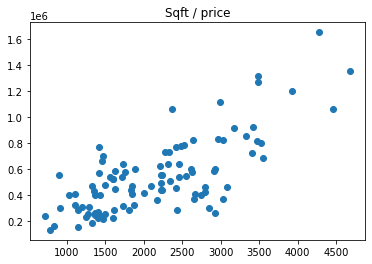

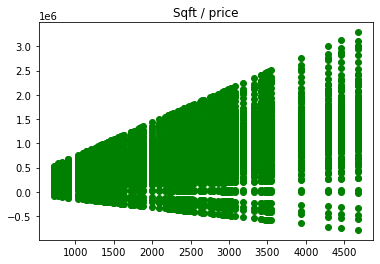

In [322]:
prices_sim=model_1_prior_simulated.stan_variable('price')
plt.scatter(df['sqft_living'], df["price"])
plt.title("Sqft / price")
plt.show()

prices_sim=model_1_prior_simulated.stan_variable('price')

for i in range(0,len(df['sqft_living'])):
    plt.scatter(df['sqft_living'], prices_sim[i], color="g")

plt.title("Sqft / price")
plt.show()

In [323]:
sqft_linspace = np.linspace(df['sqft_living'].min(),df['sqft_living'].max())


data = {'N': len(sqft_linspace),
        'sqft': sqft_linspace}
model_2_prior = CmdStanModel(stan_file='stan_2_ppc.stan')
model_2_prior_simulated = model_2_prior.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [324]:
print(df['price'].max(), df['price'].min())

1650000.0 130000.0


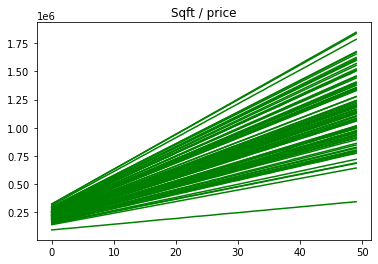

In [325]:
prices_sim=model_2_prior_simulated.stan_variable('price')

for i in range(0,len(df['sqft_living'])):
    plt.plot(range(len(sqft_linspace)), prices_sim[i], color="g")

# plt.scatter(df['sqft_living'], df["price"])

plt.title("Sqft / price")
plt.show()

<AxesSubplot:>

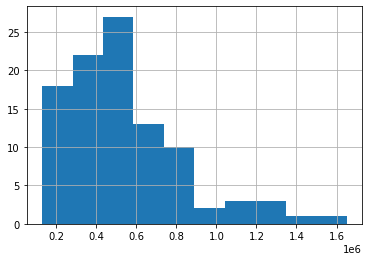

In [326]:
df['price'].hist()

In [ ]:
data = {'N': len(df['sqft_living']),
        'sqft': df['sqft_living'],
        'price': df['price']}
model_1_posterior = CmdStanModel(stan_file='stan_1_posterior.stan')
model_1_posterior_simulated = model_1_posterior.sample(data=data, seed=21370204)

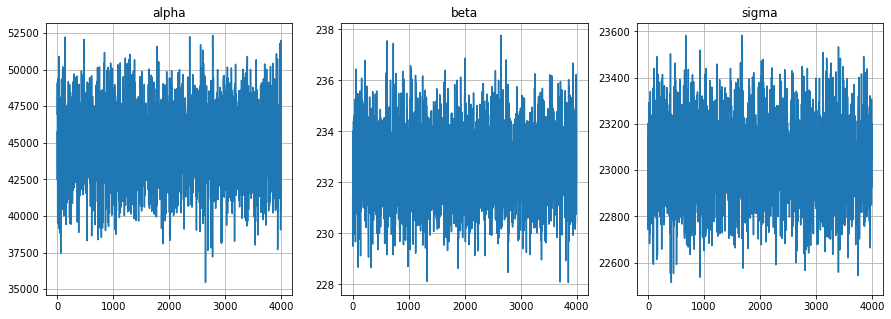

,mean,sd,hdi_3%,hdi_97%
alpha,44760.66,2373.35,40504.50,49389.60
beta,232.69,1.37,230.05,235.22
sigma,23044.51,163.75,22714.40,23327.10


In [328]:
alpha_sim = model_1_posterior_simulated.stan_variable('alpha')
beta_sim = model_1_posterior_simulated.stan_variable('beta')
sigma_sim = model_1_posterior_simulated.stan_variable('sigma')
price_sim = model_1_posterior_simulated.stan_variable('price_sim')

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].plot(alpha_sim)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].plot(beta_sim)
axs[1].grid()
axs[1].set_title('beta')
axs[2].plot(sigma_sim)
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

az.summary(model_1_posterior_simulated,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

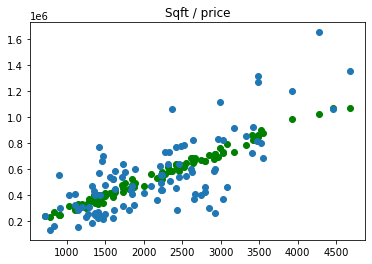

In [329]:
prices_sim=model_1_posterior_simulated.stan_variable('price_sim')

# for i in range(0,len(df['sqft_living'])):
plt.scatter(df['sqft_living'], prices_sim[1], color="g")

plt.scatter(df['sqft_living'], df["price"])

plt.title("Sqft / price")
plt.show()

## Adding second predictor to model

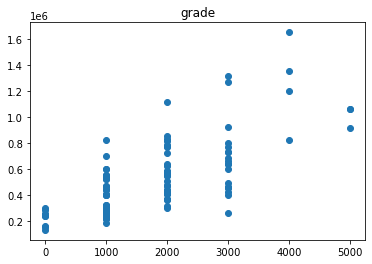

In [330]:
grade_modified = (df['grade']-6)*1000

plt.scatter(grade_modified, df["price"])
plt.title("grade")
plt.show()

In [331]:
len(df['sqft_living'])

100

In [24]:
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm

X = df[['sqft_living', 'grade']] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = df['price']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

print(model.summary())

Intercept: 
 -455991.08748734824
Coefficients: 
 [  164.62748343 82005.56326892]
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     70.74
Date:                Mon, 13 Jun 2022   Prob (F-statistic):           1.13e-19
Time:                        17:52:44   Log-Likelihood:                -1353.2
No. Observations:                 100   AIC:                             2712.
Df Residuals:                      97   BIC:                             2720.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

In [ ]:
data = {'N': len(df['sqft_living']),
        'sqft_living': df['sqft_living'],
        'grade': df['grade'],
        'price': df['price']}
model_two_param = CmdStanModel(stan_file='two_params.stan')
model_two_param_simulated = model_two_param.sample(data=data, seed=21370204)

# prices_sim=model_two_param_simulated.stan_variable('prices')

# x = range(len(df["sqft_living"]))

# plt.scatter(x, prices_sim[i], color="y")

# plt.scatter(x, df["price"])

# plt.title("Sqft / price")
# plt.show()

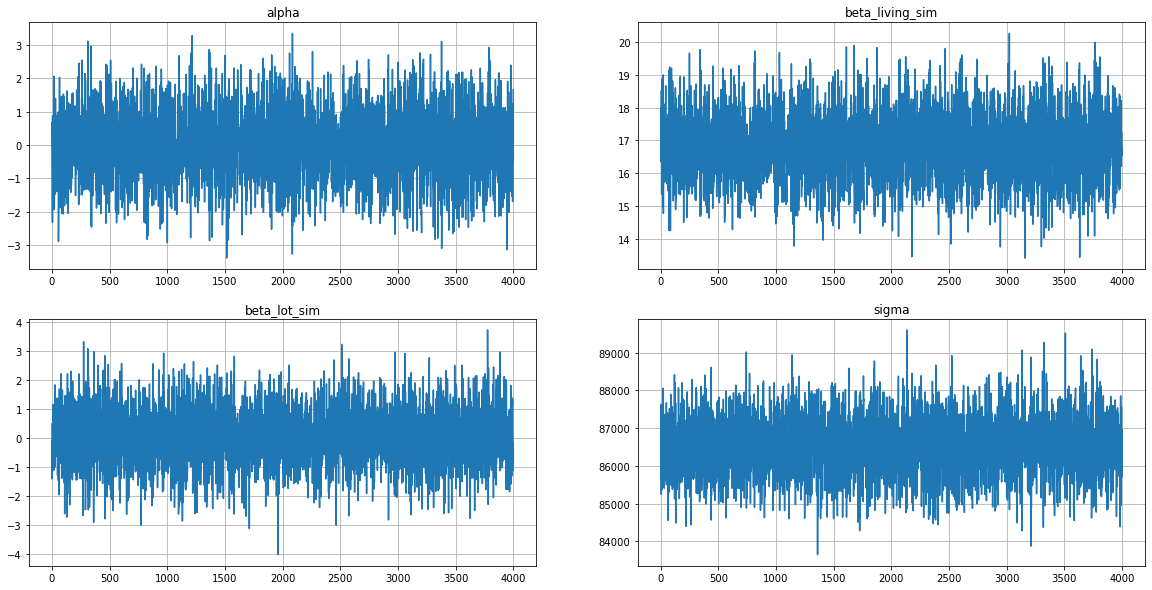

In [334]:
alpha_sim = model_two_param_simulated.stan_variable('alpha')
beta_living_sim = model_two_param_simulated.stan_variable('beta_sqft_living')
beta_lot_sim = model_two_param_simulated.stan_variable('beta_grade')
sigma_sim = model_two_param_simulated.stan_variable('sigma')
# price_sim = model_two_param_simulated.stan_variable('price')

fig, axs = plt.subplots(2,2)
fig.set_size_inches(20, 10)
axs[0][0].plot(alpha_sim)
axs[0][0].grid()
axs[0][0].set_title('alpha')
axs[0][1].plot(beta_living_sim)
axs[0][1].grid()
axs[0][1].set_title('beta_living_sim')
axs[1][0].plot(beta_lot_sim)
axs[1][0].grid()
axs[1][0].set_title('beta_lot_sim')
axs[1][1].plot(sigma_sim)
axs[1][1].grid()
axs[1][1].set_title('sigma')
plt.show()


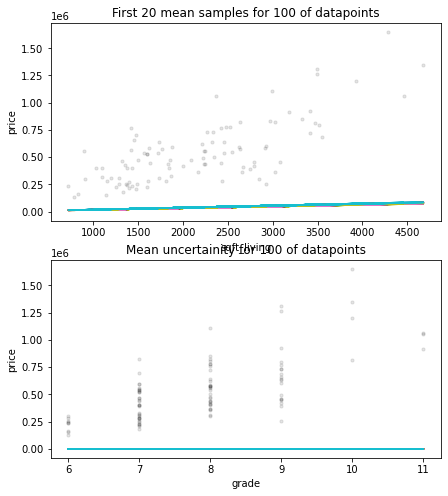

In [335]:
alpha_sim = model_two_param_simulated.stan_variable('alpha')
beta_living_sim = model_two_param_simulated.stan_variable('beta_sqft_living')
beta_grade_sim = model_two_param_simulated.stan_variable('beta_grade')
sigma_sim = model_two_param_simulated.stan_variable('sigma')
mu_sim = model_two_param_simulated.stan_variable('mu')

fig, axes = plt.subplots(2,1, figsize=(7, 8),sharey=True) 
ax0=axes[0]
for i in range(20):
    ax0.plot(df['sqft_living'],alpha_sim[i]+beta_living_sim[i]*df['sqft_living'])

ax0.scatter(df['sqft_living'],df['price'],color='black',alpha=0.1,s=10) 
ax0.set_title('First 20 mean samples for {} of datapoints'.format(len(df['sqft_living']))) 
ax0.set_ylabel('price')
ax0.set_xlabel('sqft_living')

ax1=axes[1]
ax1.scatter(df['grade'],df['price'],color='black',alpha=0.1,s=10) 

for i in range(20):
    ax1.plot(df['grade'],alpha_sim[i]+beta_grade_sim[i]*df['grade'])

ax1.set_xlabel('grade')
ax1.set_ylabel('price')
ax1.set_title('Mean uncertainity for {} of datapoints'.format(len(df['sqft_living']))) 
plt.show()

In [ ]:
# Comparing 2 models: model_1 - with AGE only, model_2 - with AGE and BMI
idata1 = az.from_cmdstanpy(posterior = model_1_posterior_simulated, log_likelihood = "log_lik")
idata2 = az.from_cmdstanpy(posterior = model_two_param_simulated, log_likelihood = "log_lik") 
compare_dict = {"model_1": idata1, "model_2": idata2}
az.compare(compare_dict, ic = "loo") # loo stands for leave one out cross validation

In [337]:
# Comparing 2 models: model_1 - with AGE only, model_2 - with AGE and BMI
idata1 = az.from_cmdstanpy(posterior = model_1_posterior_simulated, log_likelihood = "log_lik")
idata2 = az.from_cmdstanpy(posterior = model_two_param_simulated, log_likelihood = "log_lik") 
compare_dict = {"model_1": idata1, "model_2": idata2}
az.compare(compare_dict, ic = "waic") # loo stands for leave one out cross validation

/home/nicolas/anaconda3/envs/cmdstan/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/nicolas/anaconda3/envs/cmdstan/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/nicolas/anaconda3/envs/cmdstan/lib/python3.8/site-packages/arviz/stats/stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
/home/nicolas/anaconda3/envs/cmdstan/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log pred

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_2,0,-3459.110855,35.343817,0.000000,0.458748,267.827813,0.000000,True,log
model_1,1,-4717.795747,200.934140,1258.684892,0.541252,592.136473,489.145611,True,log


/home/nicolas/anaconda3/envs/cmdstan/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/nicolas/anaconda3/envs/cmdstan/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nicolas/anaconda3/envs/cmdstan/lib/python3.8/site-packages/arviz/stats/stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])


<AxesSubplot:xlabel='Log'>

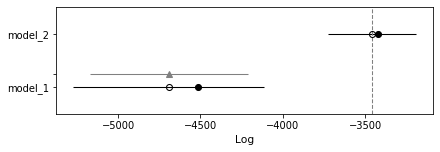

In [338]:
az.plot_compare(az.compare(compare_dict))
